**ЗАДАНИЕ №1**

Шаг 1. Сначала я загружаю и обрабатываю данные.
Затем создаю колонку с ценой на основании количества заказов, выручки и скидки (расчет цены произвожу с учетом того, что в колонке выручка значения даны со скидкой).

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
data = pd.read_excel('Тест_Junior.xlsx', sheet_name = 'Данные')
data = data.rename(columns={"СКЮ": "SKU", "Заказы, шт": "orders", "Выручка по заказам, руб": "revenue", 'Скидка, %':'discount', 'Рейтинг':'card_rating', 'Рейтинг по отзывам':'review_rating', 'Отзывы, шт':'review_num'})

data['price'] = (data['revenue']/data['orders'])/(100-data['discount'])*100
data.head()
data.describe()

In [4]:
data.isna().sum() # Считаю пропуски в данных

,0
SKU,0
orders,0
revenue,0
discount,0
card_rating,0
review_rating,0
review_num,0
price,0


Шаг 2. Визуализация данных

На графике видны значения, похожие на выбросы, однако в нашей выборке СКЮ не повторяются, а значит математические выбросы могут на самом деле отражать особенные характеристики товара. Регрессия лучше работает на данных без выбросов, однако здесь я не буду их удалять, чтобы избежать потенциальной потери важной информации.

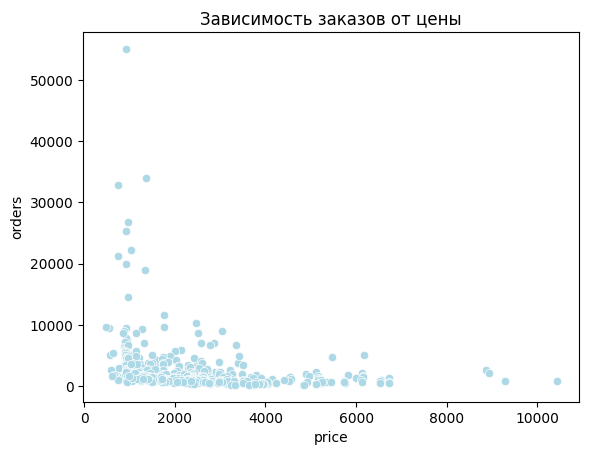

In [5]:
sns.scatterplot(x="price", y="orders", data=data, color = 'lightblue').set(title='Зависимость заказов от цены')
plt.show()

Модель, описывающая зависимость цены от спроса, может быть как линейной, так и нелинейной (ниже приведены графики).

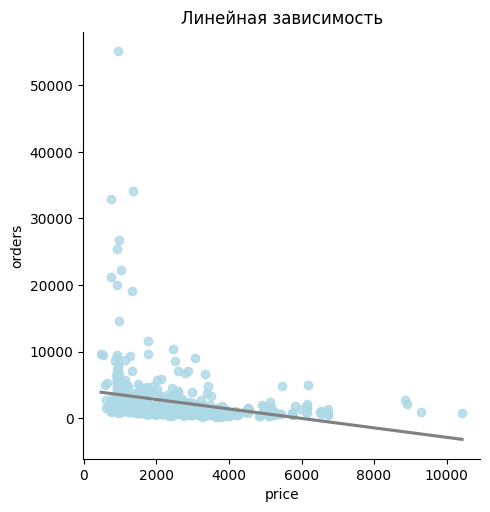

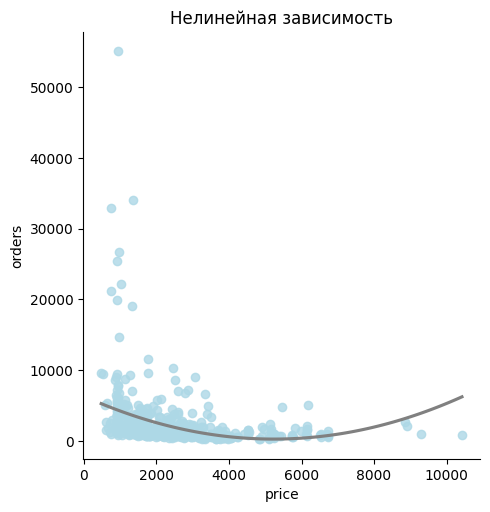

In [6]:
data_binary = data[['orders', 'price']]
sns.lmplot(y ="orders", x ="price", data = data_binary, order = 1, ci = None, line_kws={'color': 'grey'}, scatter_kws={'color': 'lightblue'}).set(title='Линейная зависимость')
plt.show()

data_binary = data[['orders', 'price']]
sns.lmplot(y ="orders", x ="price", data = data_binary, order = 2, ci = None, line_kws={'color': 'grey'}, scatter_kws={'color': 'lightblue'}).set(title='Нелинейная зависимость')
plt.show()

Нелинейность возникает для товаров роскоши - если в выборке они есть, то это может приводить к увеличению спроса при более высоких ценах. Поэтому я построю оба типа регрессий и сравню их по объясняющей силе (R^2) и информационным критериям (BIC, AIC).

Шаг 3. Линейная регрессия

In [7]:
X = data['price']
Y = data['orders']
X = sm.add_constant(X) # Добавление константы
model_linear = sm.OLS(Y, X).fit()

print("R² =", model_linear.rsquared.round(4))
print("BIC =", model_linear.bic.round(1))
print("AIC =", model_linear.aic.round(1))
model_linear.summary().tables[1]

R² = 0.061
BIC = 9757.5
AIC = 9749.0


,coef,std err,t,P>|t|,[0.025,0.975]
const,4225.2339,349.643,12.084,0.000,3538.276,4912.192
price,-0.7103,0.125,-5.689,0.000,-0.956,-0.465


Шаг 4. Нелинейная регрессия

In [8]:
X = data['price']
y = data['orders']
X_quad = np.column_stack((X, X**2))
X_quad = sm.add_constant(X_quad) # Добавление константы
model_nonlinear = sm.OLS(y, X_quad).fit()

print("R² =", model_nonlinear.rsquared.round(4))
print("BIC =", model_nonlinear.bic.round(1))
print("AIC =", model_nonlinear.aic.round(1))
model_nonlinear.summary().tables[1]

R² = 0.1001
BIC = 9742.4
AIC = 9729.8


,coef,std err,t,P>|t|,[0.025,0.975]
const,6311.4263,565.016,11.170,0.000,5201.312,7421.540
x1,-2.3202,0.368,-6.311,0.000,-3.043,-1.598
x2,0.0002,4.77e-05,4.644,0.000,0.000,0.000


Объясняющая сила у квадратической регрессии больше, чем у линейной на 4% (0.10-0.06), информационные критерии также немного лучше у квадратической.

Если все-таки есть логическая подоплека для определения нелинейной зависимости, то нужно использовать именно нелинейную модель, однако в нашем случае предположу, что в этом нет необходимости, и никакой из товаров не имеет возрастающий по цене спрос.

Разница R^2 не настолько значительна, чтобы использовать нелинейную регрессию в качестве основной и усложнять расчеты, поэтому остановлюсь на линейной модели. Для ответа возьму коэффициент в первой регрессии при цене.

\

При этом, важно понимать, что объясняющая сила у обеих моделей достаточно мала, а значит, мы упустили важные переменные в анализе. Более полную модель я соберу в задании 3, а пока я делаю предположение, что другие факторы неизвестны.

**▶▶▶ ОТВЕТ №1:**

**При увеличении цены на 1 рубль, заказы сокращаются  на 0.71 шт**

\

**ЗАДАНИЕ №2**

Для определения ценовых сегментов воспользуюсь квантилями. Разделю выборку на 4 части:
1. Четверть всех цен меньше, чем Q1 - это верхняя граница сегмента "Эконом минус" и нижняя граница сегмента "Эконом"
2. Половина всех цен меньше, чем Q2 - это верхняя граница сегмента "Эконом" и нижняя граница сегмента "Эконом плюс"
3. 75% всех цен меньше, чем Q3 - это верхняя граница сегмента "Эконом плюс" и нижняя граница сегмента "Премиум"
4. 100% всех цен меньше, чем Q4 - это верхняя граница сегмента "Премиум"

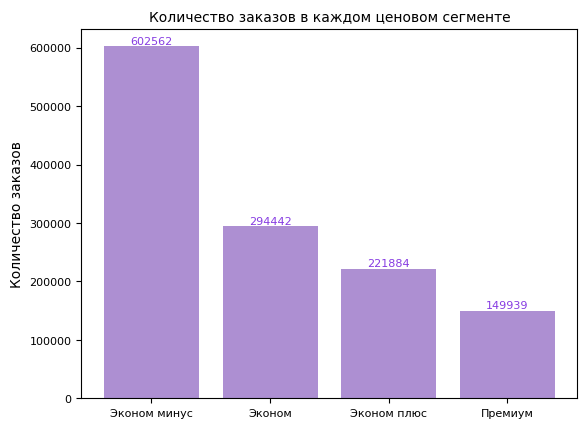

,Ценовой сегмент,Цена,Количество заказов
0,Эконом минус,476.7 - 1291.6,602562
1,Эконом,1291.6 - 1973.7,294442
2,Эконом плюс,1973.7 - 2977.6,221884
3,Премиум,2977.6 - 10423.5,149939


In [9]:
# Создаю квантили
Q0 = np.quantile(data['price'], [0]).round(1)[0]
Q1 = np.quantile(data['price'], [0.25]).round(1)[0]
Q2 = np.quantile(data['price'], [0.5]).round(1)[0]
Q3 = np.quantile(data['price'], [0.75]).round(1)[0]
Q4 = np.quantile(data['price'], [1]).round(1)[0]
segments = [
    (data['price'] <= Q1),
    (data['price'] > Q1) & (data['price'] <= Q2),
    (data['price'] > Q2) & (data['price'] <= Q3),
    (data['price'] > Q3) & (data['price'] <= Q4)]
segment_names = ['Эконом минус', 'Эконом', 'Эконом плюс', 'Премиум']
order_counts = [data.loc[segment, 'orders'].sum() for segment in segments] # количество orders в каждом сегменте

# Визуализация
plt.figure()
bars = plt.bar(segment_names, order_counts, color='#AD8FD2')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.ylabel('Количество заказов')
plt.title('Количество заказов в каждом ценовом сегменте', fontsize=10)
for bar in bars: #для надписей
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, int(yval), ha='center', va='bottom', fontsize=8, color = '#863BE2')
plt.show()


table = {'Ценовой сегмент': ['Эконом минус', 'Эконом', 'Эконом плюс', 'Премиум'],
        'Цена': [f"{Q0} - {Q1}", f"{Q1} - {Q2}", f"{Q2} - {Q3}", f"{Q3} - {Q4}"],
         'Количество заказов': order_counts}
pd.DataFrame(table)

**▶▶▶ ОТВЕТ №2:**

**Эконом минус имеет разброс цен от 476.7 до 1291.6 руб**
\
 **Сегмент эконом начинается с цены 1291.6 до цены 1973.7 руб**
\
**Эконом плюс включает в себя цены с 1973.7 по 2977.6 руб**
\
**Сегмент премиум начинается с 2977.6 руб**
 \

(Цены даны с округлением до 1 знака)

\

**ЗАДАНИЕ №3**

Для нахождения факторов, влияющих на заказы, построим линейную регрессию.

Построю модель на всех переменных кроме СКЮ (т.к. она не несет смысловой значимости) и выручки (т.к. она является следствием числа заказов).

In [10]:
y = data['orders']
X = data.drop(columns=['orders', 'revenue', 'SKU'])
X = sm.add_constant(X) # Добавляю константу

# Линейная регрессия
model = sm.OLS(y, X).fit()

# Результаты
print("\nR² =", model.rsquared.round(4))
results_summary = model.summary().tables[1]
pd.read_html(results_summary.as_html(), header=0, index_col=0)[0]


R² = 0.1392


<ipython-input-10-4b1ec3af7c82>:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pd.read_html(results_summary.as_html(), header=0, index_col=0)[0]


,coef,std err,t,P>|t|,[0.025,0.975]
const,4051.9316,8281.996,0.489,0.625,-12200.000,20300.000
discount,55.2129,15.691,3.519,0.000,24.383,86.043
card_rating,0.6596,2.372,0.278,0.781,-4.001,5.320
review_rating,-773.5251,1645.616,-0.470,0.639,-4006.795,2459.745
review_num,0.0508,0.012,4.233,0.000,0.027,0.074
price,-0.7592,0.150,-5.065,0.000,-1.054,-0.465


Факторами, статистически значимо влияющими на количество заказов, оказались: скидка, цена и количество отзывов. Остальные переменные имеют p-value > 0.05, то есть вероятность ошибиться, поверив в их коэффициенты, слишком велика.

Модель имеет объясняющую силу 13.9% (R^2 = 0.139), что уже в два раза больше, чем однофакторная регрессия, однако все еще достаточно мало. Возможно, этот показатель можно повысить, добавив в модель другие признаки, потенциально влияющие на число заказов - например, сезонность.

Также можно заметить, что коэффициент при цене немного повысился (с 0.71 до 0.76). Коэффициент 0.76 заслуживает большего доверия, т.к. он был получен благодаря учету факторов, которые не были проанализированы в первом задании.

**▶▶▶ ОТВЕТ №3:**

**При увеличении скидки на 1%, количество заказов увеиличивается на 55.2 штуки**
\
**При увеличении цены на 1 руб, количество заказов уменьшается на 0.76 штук**
\
**При увеличении отзывов на 1, количество заказов увеличивается на 0.05 штук**
